<a href="https://colab.research.google.com/github/POde97/CellIDpy/blob/main/CellID_Example_Git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Install Dependencies**

In [ ]:
import os
!git clone https://github.com/POde97/CellIDpy.git
os.chdir("CellIDpy/")
!pip install . 
os.chdir("..")

Cloning into 'CellIDpy'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 176 (delta 27), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (176/176), 436.57 KiB | 827.00 KiB/s, done.
Resolving deltas: 100% (86/86), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/CellIDpy
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━

#**Download data and reference gene list**

- scRna-seq data of https://www.cell.com/cell-systems/fulltext/S2405-4712(16)30266-6?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2405471216302666%3Fshowall%3Dtrue

- reference gene lsit from https://panglaodb.se/


In [ ]:
import pandas as pd
url="https://panglaodb.se/markers/PanglaoDB_markers_27_Mar_2020.tsv.gz"
c=pd.read_csv(url, sep='\t', header=0)

c = c[c["species"].isin(["Hs","Mm Hs"])]
c = c[c["organ"]=="Pancreas"]
c = pd.DataFrame(c.groupby('cell type')['official gene symbol'].apply(list))
c.columns = ["signature"]


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10rHN_60c2NJvVh8HXcY7P6jNBS9ptp5E' -O "Baron.h5ad"

--2023-03-27 15:44:45--  https://docs.google.com/uc?export=download&id=10rHN_60c2NJvVh8HXcY7P6jNBS9ptp5E
Resolving docs.google.com (docs.google.com)... 64.233.188.113, 64.233.188.139, 64.233.188.100, ...
Connecting to docs.google.com (docs.google.com)|64.233.188.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cp81ur6jnp2qt95vkm88jsf2ii1b92bt/1679931825000/15472246493323528491/*/10rHN_60c2NJvVh8HXcY7P6jNBS9ptp5E?e=download&uuid=ea650290-1f01-491f-9bca-a81133d5fd6a [following]
--2023-03-27 15:44:48--  https://doc-0k-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cp81ur6jnp2qt95vkm88jsf2ii1b92bt/1679931825000/15472246493323528491/*/10rHN_60c2NJvVh8HXcY7P6jNBS9ptp5E?e=download&uuid=ea650290-1f01-491f-9bca-a81133d5fd6a
Resolving doc-0k-8c-docs.googleusercontent.com (doc-0k-8c-docs.googleusercontent.com)... 108.177.125.132, 2404:6800

#**Load data and perform CellID labelling using reference gene list**

- For an in depth explanation of Cell-ID inner working see: https://www.nature.com/articles/s41587-021-00896-6

In brief data are loaded in AnnData object (data structure of scanpy). Only protein coding genes are retained (not compulsory but improve prediction). Further CellID() class generate CellID perform Multiple correspondence analysis and calculate per cell gene signature. Finally Hypergeom() class labels cells by using an hypergeometric test. 

In [ ]:
import scanpy as sc 
from CellIDpy import ProteinCoding


adata = sc.read("Baron.h5ad")
adata = adata[:,adata.var_names.isin(ProteinCoding.HgProteinCoding())].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)



In [ ]:
from CellIDpy import CellID
import time

start_time = time.time()
cID = CellID.CellID(adata)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time, "seconds")

Computing Fuzzy Matrix
Computing SVD
Computing coordinates
Computing Cell-Genes Distances
Build signature with TOP 200 closest genes
Storing MCA in adata object
Elapsed time:  145.67891716957092 seconds


In [ ]:
from CellIDpy import HyperG
HGT = HyperG.Hypergeom(cID.ad,c)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score
adata1 = cID.ad[cID.ad.obs["gs_prediction"]!="unassigned"]
accuracy_score(list(adata1.obs["cell.type"]), list(adata1.obs["gs_prediction"]))

0.9574283231972198

#**Visualization**


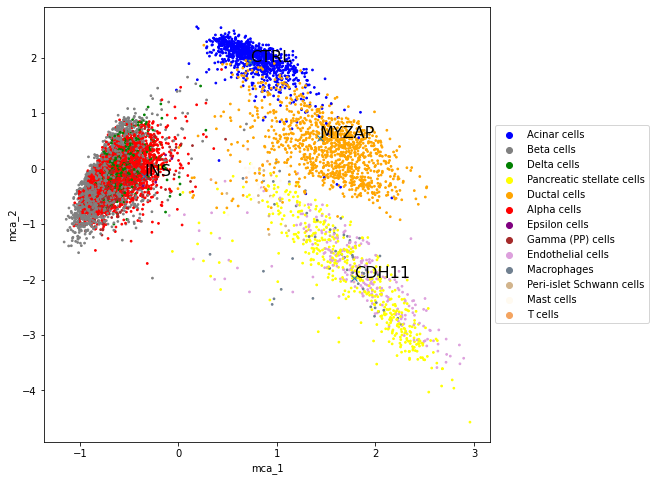

In [ ]:
from CellIDpy import mcaplot
mcaplot.MCAplot(cID,"cell.type",genep = ["CTRL", "INS", "MYZAP", "CDH11"])